Esse projeto se baseará na análise de sentimentos de tweets, obtidos de base de dados do kaggle disponível em https://www.kaggle.com/code/akshayarajasekaran/cd-sentiment-analysis-of-tweets/data

### Importando as bibliotecas:

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
import re
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import spacy
from sklearn.decomposition import TruncatedSVD

### Importando os dados:

In [2]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', names=['target','id','date','flag','user','text'], header=None, encoding='latin-1')

In [3]:
df

target          id                          date      flag  \
0             0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1             0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2             0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3             0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4             0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
...         ...         ...                           ...       ...   
1599995       4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996       4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997       4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998       4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999       4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    user                                               text  
0        _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1          scotthamilton  is upset that he can't update his Facebook by ...  
2               mattycus  @Kenichan I dived many times for the ball. Man...  
3                ElleCTF    my whole body feels itchy and like its on fire   
4                 Karoli  @nationwideclass no, it's not behaving at all....  
...                  ...                                                ...  
1599995  AmandaMarie1028  Just woke up. Having no school is the best fee...  
1599996      TheWDBoards  TheWDB.com - Very cool to hear old Walt interv...  
1599997           bpbabe  Are you ready for your MoJo Makeover? Ask me f...  
1599998     tinydiamondz  Happy 38th Birthday to my boo of alll time!!! ...  
1599999   RyanTrevMorris  happy #charitytuesday @theNSPCC @SparksCharity...  

[1600000 rows x 6 columns]

In [4]:
df['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

Vê-se que a variável target está dividida entre 0 e 4, sendo 0 para tweets negativos e 4 tweets positivos. Sendo assim, serão renomeadas para 0 (negativos) e 1(positivos). Além disso, serão selecionadas apenas as colunas relevantes

In [5]:
df['target'] = df['target'].replace(4,1)
df = df[['target','text']]
df.head()

target                                               text
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0  is upset that he can't update his Facebook by ...
2       0  @Kenichan I dived many times for the ball. Man...
3       0    my whole body feels itchy and like its on fire 
4       0  @nationwideclass no, it's not behaving at all....

### Pré-Processamento

O primeiro passo do pré-processamento é tratar os emojis, os links e as menções.
* Para os emojis, será utilizado um dicionário incluso no desafio do kaggle, mas separando cada emoji em negativos, positivos e neutros.
* Para links, serão removidos via regex com os inicios de site (http, https, www)
* Para menções, serão removidas as palavras iniciadas por @
* As Hashtags serão mantidas

Tudo isso será incluido em uma função de pré-processamento

In [6]:
sw = stopwords.words('english')

nlp = spacy.load('en_core_web_sm')

def preprocess(tweet, lem=False, stem=False, join=False):

    emojis = {':)': 'good', ':-)': 'good', ';d': 'good', ':-e': 'neutral', ':(': 'bad', 
          ':-(': 'bad', ':-<': 'bad', ':p': 'good', ':o': 'neutral',
          ':-@': 'bad', ':@': 'good',':-$': 'bad', ':\\': 'bad', 
          ':#': 'bad', ':x': 'bad', ':^)': 'good', ':-&': 'bad', '$_$': 'neutral',
          '@@': 'bad', ':-!': 'bad', ':-d': 'good', ':-0': 'neutral', 'o.o': 'bad',
          '<(-_-)>': 'neutral', 'd[-_-]b': 'neutral', ":'-)": 'good', ';)': 'good', 
          ';-)': 'good', 'o:-)': 'good','O*-)': 'good','(:-d': 'good', '=^.^=': 'neutral'}

    small_tweet = tweet.lower()

    no_mention = re.sub('@[^\s]+',' ', small_tweet)   #Remove todas as menções a usuários

    no_links = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)",' ',no_mention)

    for emoji in emojis.keys():
        no_emoji = no_links.replace(emoji, emojis[emoji])     #Troca os emojis pela classificação

    clean = re.sub("[^a-zA-Z0-9#]",' ', no_emoji)      #Remove tudo que não for a-z, A-Z, 0-9 e #

    if join == True:

        if lem == True:     #Caso seja selecionado lematização:
            lem_tokens = nlp(clean)     #Aplica biblioteca spacy

            lem_words = [token.lemma_ for token in lem_tokens]      #Aplica tokenização e lematização

            lem_clean = [token for token in lem_words if token not in sw]       #Remove stopwords dos tokens

            lem_str = ' '.join(lem_clean)       #Transforma a frase em string completa

            return lem_str

        else:

            tokens = word_tokenize(clean)    #Tokeniza o texto limpo

            clean_tokens = [word for word in tokens if word not in sw]      #Remove Stopwords

            if stem == True:      #Caso não seja selecionada lematização, mas stematização

                stem_tokens = [PorterStemmer().stem(word) for word in clean_tokens]     #Aplica stematização nos tokens

                stem_str = ' '.join(stem_tokens)        #Transforma a frase em string completa

                return stem_str
        
            full_str = ' '.join(clean_tokens) #Caso seja selecionado apenas o join

            return full_str

    tokens = word_tokenize(clean)   

    clean_tokens = [word for word in tokens if word not in sw]     

    return clean_tokens


Aplicando o pré-processamento ao df, será gerada uma coluna na base com os tweets tokenizados para a análise visual:

In [7]:
df['new_tweet_token'] = df['text'].apply(lambda x: preprocess(x))

C:\Users\leokm\AppData\Local\Temp\ipykernel_21236\1326926518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_tweet_token'] = df['text'].apply(lambda x: preprocess(x))


### Visualização dos Dados

Para a visualização dos dados, serão feitas nuvens de palavras com base nos dados limpos, para as bases de tweets positivos e negativos:

In [8]:
positive_df = df[df['target']==1]['new_tweet_token']
negative_df = df[df['target']==0]['new_tweet_token']
list_pos = []
list_neg = []
for i in positive_df:
    for token in i:
        list_pos.append(token)
for i in negative_df:
    for token in i:
        list_neg.append(token)
str_pos = ' '.join(list_pos)
str_neg = ' '.join(list_neg)


* Tweets positivos:

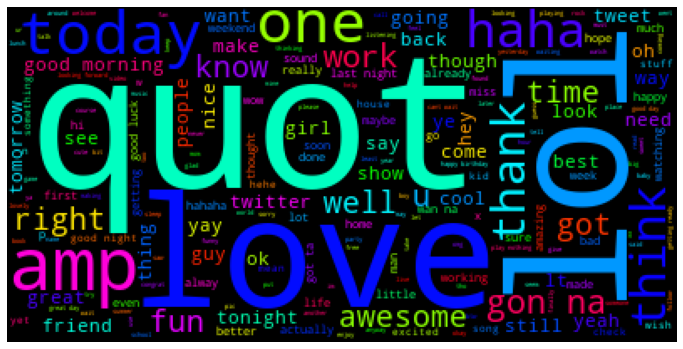

In [9]:
wordcloud_pos = WordCloud(background_color='black',colormap='hsv').generate(str_pos)
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud_pos)
plt.axis("off")
plt.show()

Vejamos as palavras que mais se repetem em tweets positivos:

In [10]:
freq_pos = dict(sorted(nltk.FreqDist(list_pos).items(), key=lambda item: item[1],reverse = True))
for k, v in freq_pos.items(): 
  print(str(k) + ':' + str(v))

good:62112
love:47699
day:47208
quot:45806
like:37518
get:36502
lol:36121
thanks:34509
got:31996
u:31925
going:30933
time:30428
today:30101
go:28336
new:26936
one:26674
#:26218
amp:26218
see:25807
know:25734
great:25307
back:23858
night:23568
well:23296
haha:21666
morning:20832
happy:20530
im:19964
think:19525
work:19520
twitter:19470
hope:19209
really:18531
fun:18520
2:18215
oh:17306
much:17024
nice:16969
3:16419
na:16291
home:15919
thank:15820
tomorrow:14875
awesome:14469
watching:14378
still:14299
wait:14055
hey:14044
need:13667
would:13323
last:13279
right:12812
yes:12797
yeah:12746
make:12657
way:12644
tonight:12591
better:12474
want:12428
come:12178
lt:11579
best:11275
getting:10844
gon:10765
cool:10549
yay:10517
everyone:10428
people:10264
bed:9864
first:9735
weekend:9590
say:9548
week:9546
sleep:9533
soon:9314
next:9300
sure:9268
though:9213
follow:9142
amazing:9034
ok:8979
4:8694
days:8613
little:8570
show:8551
please:8516
let:8515
done:8492
movie:8475
life:8454
take:8450
x:83

* Tweets negativos:

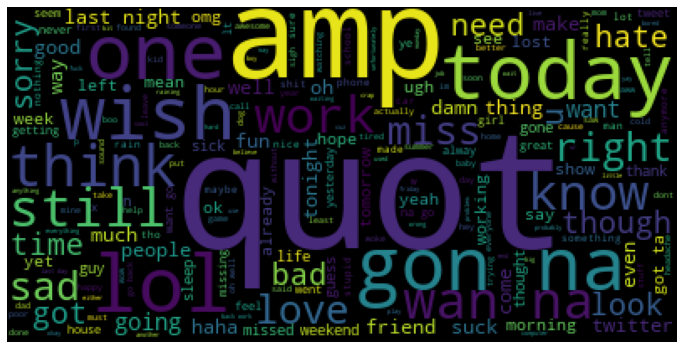

In [11]:
wordcloud_neg = WordCloud(background_color='black',colormap='viridis').generate(str_neg)
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.show()

In [12]:
freq_neg = dict(sorted(nltk.FreqDist(list_neg).items(), key=lambda item: item[1],reverse = True))
for k, v in freq_neg.items(): 
  print(str(k) + ':' + str(v))

go:45579
get:45541
work:45397
like:41047
day:39864
got:38594
today:38118
going:33684
back:33076
really:31500
miss:30711
im:30649
want:29865
still:29263
good:29204
sad:27918
time:27519
one:27262
know:26314
quot:26083
na:25777
2:24664
home:24515
u:23988
lol:23136
wish:22460
last:22454
oh:22452
amp:22388
need:22301
feel:21956
think:21879
bad:21724
sorry:20986
see:20553
night:20031
much:20010
well:19484
tomorrow:19244
#:18921
sleep:18450
hate:17208
love:16989
3:16256
new:15506
right:15069
though:14799
hope:14678
sick:14616
would:14006
could:13837
morning:13771
getting:13519
tonight:13421
gon:13331
twitter:13264
come:12938
school:12881
dont:12770
cant:12424
bed:12385
even:12370
make:12308
week:12197
tired:12149
wan:11992
way:11819
never:11234
feeling:11029
working:10858
better:10771
days:10618
people:10290
fun:10172
4:10064
sucks:9905
haha:9838
yeah:9680
lost:9531
long:9511
phone:9420
next:9355
already:9340
damn:9336
find:9297
ugh:9053
weekend:8913
take:8661
yet:8634
soon:8527
away:8491
hou

Percebe-se que algumas das palavras mais citadas em ambos os casos são palavras que não estão nas stopwords mas que não possuem cunho positivo ou negativo. Desta forma, estas serão inclusas às stopwords e novas nuvens de palavras serão geradas

In [13]:
sw.append('quot')
sw.append('amp')
sw.append('today')
sw.append('one')
sw.append('day')
sw.append('go')
sw.append('get')
sw.append('got')
sw.append('u')
sw.append('going')
sw.append('think')
sw.append('know')
sw.append('time')
sw.append('gon')
sw.append('wan')
sw.append('na')
sw.append(' ')
sw.append('  ')
sw.append('   ')

In [14]:
new_str_pos = ' '.join([word for word in list_pos if word not in sw])
new_str_neg = ' '.join([word for word in list_neg if word not in sw])

Tweets positivos:

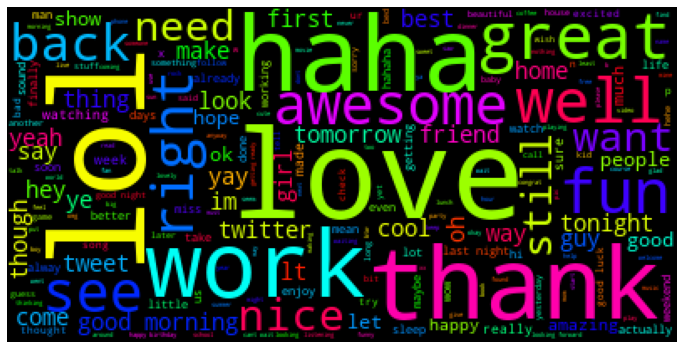

In [15]:
new_wordcloud_pos = WordCloud(background_color='black',colormap='hsv').generate(new_str_pos)
plt.figure(figsize = (12, 12))
plt.imshow(new_wordcloud_pos)
plt.axis("off")
plt.show()

Tweets negativos:

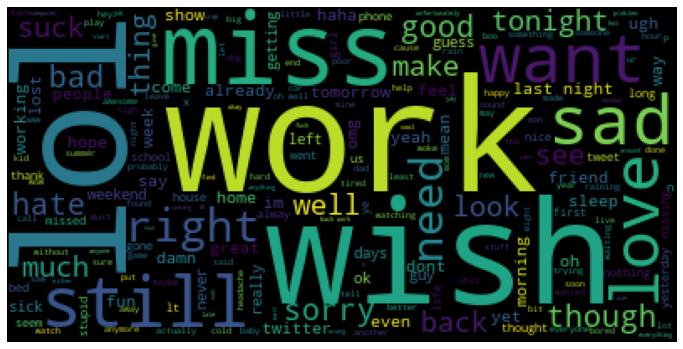

In [16]:
new_wordcloud_neg = WordCloud(background_color='black',colormap='viridis').generate(new_str_neg)
plt.figure(figsize = (12, 12))
plt.imshow(new_wordcloud_neg)
plt.axis("off")
plt.show()

Percebe-se que agora é mais perceptível a divisão entre palavras de cunho positivo e negativo nas duas categorias de tweets. O processamento será então aplicado novamente, com as novas stopwords:

In [ ]:
df['new_tweet_clean'] = df['text'].copy().apply(lambda x: preprocess(x, join=True))
df['new_tweet_lemma'] = df['text'].copy().apply(lambda x: preprocess(x, lem=True, join=True))
df['new_tweet_stem'] = df['text'].copy().apply(lambda x: preprocess(x, stem=True, join=True))

O novo df será salvo em csv, para evitar ter que aplicar o custoso pré-processamento novamente:

In [18]:
df.to_csv('tweets_database.csv')

In [2]:
df = pd.read_csv('tweets_database.csv', index_col=0, encoding='latin-1')

In [3]:
df.head()

target                                               text  \
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1       0  is upset that he can't update his Facebook by ...   
2       0  @Kenichan I dived many times for the ball. Man...   
3       0    my whole body feels itchy and like its on fire    
4       0  @nationwideclass no, it's not behaving at all....   

                                     new_tweet_token  \
0  ['awww', 'bummer', 'shoulda', 'got', 'david', ...   
1  ['upset', 'update', 'facebook', 'texting', 'mi...   
2  ['dived', 'many', 'times', 'ball', 'managed', ...   
3  ['whole', 'body', 'feels', 'itchy', 'like', 'f...   
4                         ['behaving', 'mad', 'see']   

                                     new_tweet_clean  \
0               awww bummer shoulda david carr third   
1  upset update facebook texting might cry result...   
2  dived many times ball managed save 50 rest bounds   
3                   whole body feels itchy like fire   
4                                   behaving mad see   

                                     new_tweet_lemma  \
0               awww bummer shoulda david carr third   
1  upset update facebook texte might cry result s...   
2         I dive many ball manage save 50 rest bound   
3                    whole body feel itchy like fire   
4                               behave I mad I I see   

                                      new_tweet_stem  
0               awww bummer shoulda david carr third  
1  upset updat facebook text might cri result sch...  
2       dive mani time ball manag save 50 rest bound  
3                    whole bodi feel itchi like fire  
4                                      behav mad see

In [4]:
df['new_tweet_clean'] = df['new_tweet_clean'].astype(str)
df['new_tweet_lemma'] = df['new_tweet_lemma'].astype(str)
df['new_tweet_stem'] = df['new_tweet_stem'].astype(str)

### Modelagem
    

Para o processo de modelagem, será definida uma função que aplicará os estimadores automaticamente nos dados selecionados:

In [27]:
def solver(X,y,estimator,folds=5,tuning=False,params=None,roc=True,dim_red=False,score='roc_auc'):

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)     #Faz o Split dos dados

    if dim_red==True:

        pipeline = Pipeline([('tfidf', TfidfVectorizer()),('lsa',TruncatedSVD(random_state=42)),('model', estimator)])       #Caso seja selecionada redução de dimensionalidade (dim_red), inclui o LSA no pipeline

    else:

        pipeline = Pipeline([('tfidf', TfidfVectorizer()),('model', estimator)])        #Caso não seja selecionado PCA, pipeline apenas com TfIdf e o estimador

    if tuning==True:

        fold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)   

        grid = GridSearchCV(pipeline,params,n_jobs=-1,cv=fold, scoring= score)      #Caso seja selecionado tuning, o pipeline é inserido num grid search. Os parâmetros são passados externamente.

        grid.fit(X_train,y_train)       #Para o caso com tuning, o fit e o predict são realizados no grid

        y_pred = grid.predict(X_test)

        return show(X_test,y_pred,y_test,grid,roc,tuning)       #Chama a função que mostra os resultados
        
    pipeline.fit(X_train,y_train)       #Caso não passe pelo tuning, o fit e o predict serão feitos diretamente no pipeline

    y_pred = pipeline.predict(X_test)       
    
    return show(X_test,y_pred,y_test,pipeline,roc)      

def show(X_test,y_pred,y_test,predict,roc,tuning=None):     #Função que mostra os resultados

    print('===== CLASSIFICATION REPORT =====')
    print(classification_report(y_test, y_pred))        #Printa o classification report
    print('\n')
    print('===== ACCURACY SCORE =====')
    print(accuracy_score(y_test, y_pred))       #Printa a accuracy
    print('\n')
    if roc == False:
        return ('Roc curve not predicted')      #Para estimadores que não possuem o método predict_proba, encerra a função aqui para evitar erros

    y_proba = predict.predict_proba(X_test)         #Para estimadores que possuem predict_proba, calcula o mesmo para gerar a curva ROC
    y_proba = y_proba[:, 1]
    fp, tp, thresholds = roc_curve(y_test, y_proba)
    
    print('===== ROC CURVE =====')
    plt.plot(fp, tp, color = 'red', label = 'ROC')      #Plota a curva ROC
    plt.plot([0,1], [0,1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend()
    plt.show()
    print('\n')
    print('===== ROC AUC SCORE =====')
    print(roc_auc_score(y_test, y_proba))       #Plota o score da curva ROC

    if tuning:
        print ('\n')
        print ('===== BEST PARAMETERS =====')
        return predict.best_params_     #Para casos com tuning, printa os melhores parâmetros selecionados para o modelo

O modelo será executado primeiramente utilizando regressão logistica, para casos com stem e lem, sem tuning de hiperparâmetros:

* Base Sem Tratamento:

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    239361
           1       0.77      0.80      0.78    240639

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000



===== ACCURACY SCORE =====
0.7783375


===== ROC CURVE =====


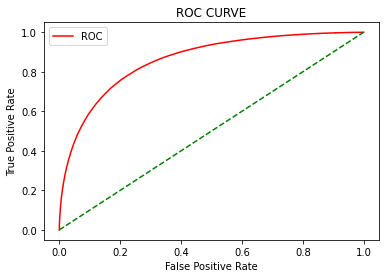



===== ROC AUC SCORE =====
0.8592518900189408


In [18]:
solver(X=df['new_tweet_clean'],y=df['target'],estimator=LogisticRegression(random_state=42,max_iter = 10000))

* Base com Stemmer:


===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.78      0.75      0.77    239361
           1       0.76      0.79      0.78    240639

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



===== ACCURACY SCORE =====
0.7733666666666666


===== ROC CURVE =====


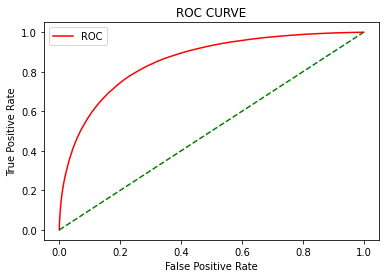



===== ROC AUC SCORE =====
0.8538649543488198


In [22]:
solver(X=df['new_tweet_stem'],y=df['target'],estimator=LogisticRegression(random_state=42,max_iter = 10000))

* Base com Lemmatizer:

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.78      0.75      0.77    239361
           1       0.76      0.79      0.78    240639

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



===== ACCURACY SCORE =====
0.7712354166666666


===== ROC CURVE =====


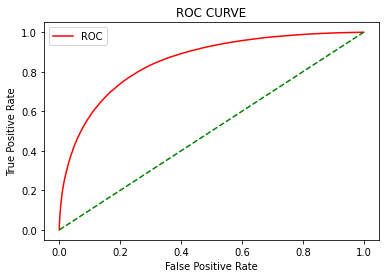



===== ROC AUC SCORE =====
0.8517044324966249


In [23]:
solver(X=df['new_tweet_lemma'],y=df['target'],estimator=LogisticRegression(random_state=42,max_iter=10000))

Percebe-se que o melhor resultado foi obtido para a base limpa, sem stematização ou lematização. Para fins de comparação, o modelo será executado com outros estimadores:

    * XGBoost

* Base limpa:

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.79      0.64      0.70    239361
           1       0.70      0.83      0.76    240639

    accuracy                           0.73    480000
   macro avg       0.74      0.73      0.73    480000
weighted avg       0.74      0.73      0.73    480000



===== ACCURACY SCORE =====
0.7325041666666666


===== ROC CURVE =====


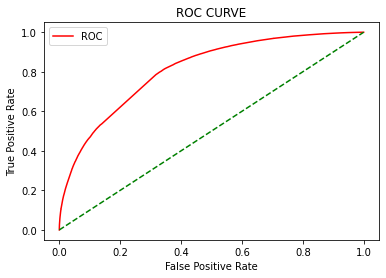



===== ROC AUC SCORE =====
0.8100523416993439


In [30]:
solver(X=df['new_tweet_clean'],y=df['target'],estimator=XGBClassifier())

* Base com Stemmer:

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.79      0.65      0.71    239361
           1       0.70      0.82      0.76    240639

    accuracy                           0.74    480000
   macro avg       0.75      0.74      0.74    480000
weighted avg       0.74      0.74      0.74    480000



===== ACCURACY SCORE =====
0.7379666666666667


===== ROC CURVE =====


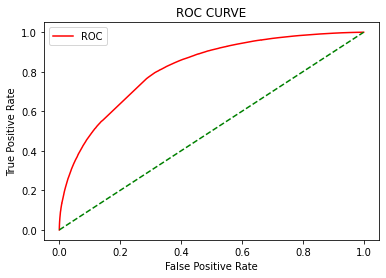



===== ROC AUC SCORE =====
0.8156652105509452


In [29]:
solver(X=df['new_tweet_stem'],y=df['target'],estimator=XGBClassifier())

* Base com Lemmatizer:

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.78      0.65      0.71    239361
           1       0.70      0.82      0.75    240639

    accuracy                           0.73    480000
   macro avg       0.74      0.73      0.73    480000
weighted avg       0.74      0.73      0.73    480000



===== ACCURACY SCORE =====
0.7344291666666667


===== ROC CURVE =====


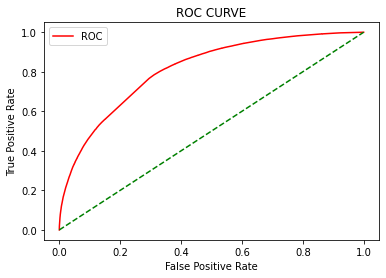



===== ROC AUC SCORE =====
0.811451834450078


In [26]:
solver(X=df['new_tweet_lemma'],y=df['target'],estimator=XGBClassifier())

    *   LinearSVC

* Base limpa:

In [33]:
solver(X=df['new_tweet_clean'],y=df['target'],estimator=LinearSVC(),roc=False)

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.78      0.75      0.77    239361
           1       0.76      0.79      0.77    240639

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



===== ACCURACY SCORE =====
0.77046875




'Roc curve not predicted'

* Base com Stemmer:

In [37]:
solver(X=df['new_tweet_stem'],y=df['target'],estimator=LinearSVC(),roc=False)

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.78      0.75      0.76    239361
           1       0.76      0.78      0.77    240639

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



===== ACCURACY SCORE =====
0.76636875




'Roc curve not predicted'

* Base com Lemmatizer:

In [35]:
solver(X=df['new_tweet_lemma'],y=df['target'],estimator=LinearSVC(),roc=False)

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.77      0.75      0.76    239361
           1       0.76      0.78      0.77    240639

    accuracy                           0.76    480000
   macro avg       0.76      0.76      0.76    480000
weighted avg       0.76      0.76      0.76    480000



===== ACCURACY SCORE =====
0.76369375




'Roc curve not predicted'

    * Multinomial Naive Bayes

* Base limpa:

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.75      0.77      0.76    239361
           1       0.77      0.75      0.76    240639

    accuracy                           0.76    480000
   macro avg       0.76      0.76      0.76    480000
weighted avg       0.76      0.76      0.76    480000



===== ACCURACY SCORE =====
0.7612291666666666


===== ROC CURVE =====


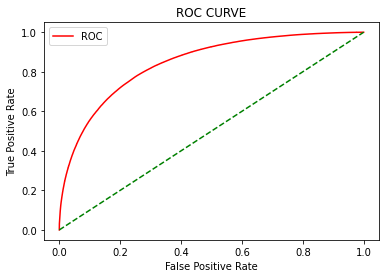



===== ROC AUC SCORE =====
0.8441775435055338


In [40]:
solver(X=df['new_tweet_clean'],y=df['target'],estimator=MultinomialNB())

* Base com Stemmer:

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.75      0.77      0.76    239361
           1       0.76      0.74      0.75    240639

    accuracy                           0.76    480000
   macro avg       0.76      0.76      0.76    480000
weighted avg       0.76      0.76      0.76    480000



===== ACCURACY SCORE =====
0.75565625


===== ROC CURVE =====


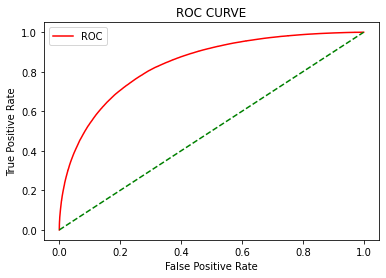



===== ROC AUC SCORE =====
0.8378949261735095


In [41]:
solver(X=df['new_tweet_stem'],y=df['target'],estimator=MultinomialNB())

* Base com Lemmatizer:

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.75      0.76      0.76    239361
           1       0.76      0.74      0.75    240639

    accuracy                           0.75    480000
   macro avg       0.75      0.75      0.75    480000
weighted avg       0.75      0.75      0.75    480000



===== ACCURACY SCORE =====
0.7532895833333333


===== ROC CURVE =====


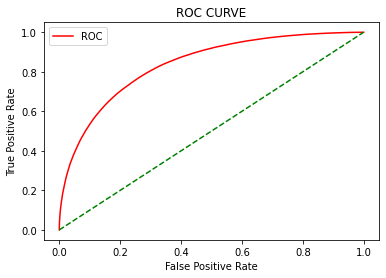



===== ROC AUC SCORE =====
0.8360611231130877


In [42]:
solver(X=df['new_tweet_lemma'],y=df['target'],estimator=MultinomialNB())

Percebe-se que o melhor resultado foi obtido usando regressão logística como estimador. Será por fim aplicado tuning de hiperparâmetros para verificar se há a possibilidade de melhoria nos resultados:

In [13]:
param_grid = {          
        'model__C': [0.01,0.1, 1.0, 10],
        'model__class_weight': [None, 'balanced'],
        'model__penalty': ['l1', 'l2'],
        'model__solver' : ['liblinear']
        },

* Base limpa

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    239361
           1       0.77      0.80      0.78    240639

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000



===== ACCURACY SCORE =====
0.7783333333333333


===== ROC CURVE =====


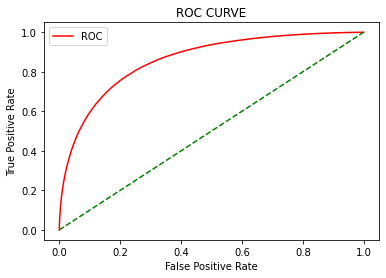



===== ROC AUC SCORE =====
0.8592538011956832


===== BEST PARAMETERS =====


{'model__C': 1.0,
 'model__class_weight': None,
 'model__penalty': 'l2',
 'model__solver': 'liblinear'}

In [14]:
solver(X=df['new_tweet_clean'],y=df['target'],estimator=LogisticRegression(random_state=42,max_iter=10000),tuning=True,params=param_grid,folds=5)

* Base com Stemmer

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.78      0.75      0.77    239361
           1       0.76      0.79      0.78    240639

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



===== ACCURACY SCORE =====
0.7734


===== ROC CURVE =====


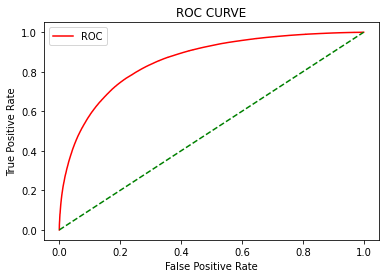



===== ROC AUC SCORE =====
0.8539604157547034


===== BEST PARAMETERS =====


{'model__C': 1.0,
 'model__class_weight': None,
 'model__penalty': 'l2',
 'model__solver': 'liblinear'}

In [15]:
solver(X=df['new_tweet_stem'],y=df['target'],estimator=LogisticRegression(random_state=42,max_iter=10000),tuning=True,params=param_grid,folds=5)

* Base com Lemmatizer

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.78      0.75      0.77    239361
           1       0.76      0.79      0.78    240639

    accuracy                           0.77    480000
   macro avg       0.77      0.77      0.77    480000
weighted avg       0.77      0.77      0.77    480000



===== ACCURACY SCORE =====
0.7712520833333333


===== ROC CURVE =====


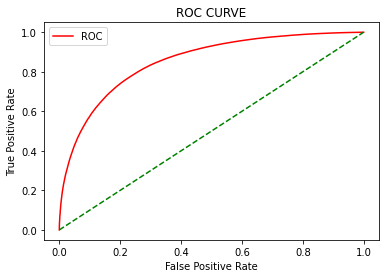



===== ROC AUC SCORE =====
0.8517478757559789


===== BEST PARAMETERS =====


{'model__C': 1.0,
 'model__class_weight': None,
 'model__penalty': 'l2',
 'model__solver': 'liblinear'}

In [16]:
solver(X=df['new_tweet_lemma'],y=df['target'],estimator=LogisticRegression(random_state=42,max_iter=10000),tuning=True,params=param_grid,folds=5)

Percebe-se que não há praticamente nenhuma melhora utilizando tuning em comparação com o estimador padrão, então para o próximo passo será utilizado o padrão. Finalmente, será realizada uma ultima tentativa aplicanda redução de dimensionalidade aos dados, em busca de melhores resultados em relação ao modelo padrão. Como o PCA não trabalha bem com matrizes esparsas, para este caso será usado o TruncatedSVD (LSA), que funciona bem para este caso.

Será também aplicado tuning ao LSA, em busca da melhor quantidade de features.

    *   LSA

In [34]:
param_grid = {          #Serão declarados parâmetros para a seleção da quantidade de features no LSA com tuning
        'lsa__n_components': [1,10,20,50,100,200,300,500,1000],
        'lsa__algorithm': ['arpack','randomized']
        }

*   Base limpa:

c:\Users\leokm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\leokm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\leokm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\leokm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklea

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.74      0.67      0.71    239361
           1       0.70      0.77      0.74    240639

    accuracy                           0.72    480000
   macro avg       0.72      0.72      0.72    480000
weighted avg       0.72      0.72      0.72    480000



===== ACCURACY SCORE =====
0.72176875


===== ROC CURVE =====


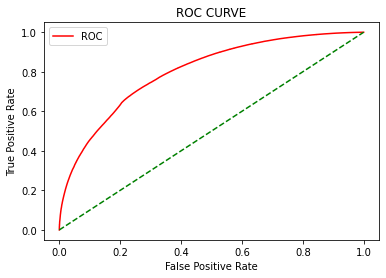



===== ROC AUC SCORE =====
0.8003984662587177


===== BEST PARAMETERS =====


{'lsa__algorithm': 'arpack', 'lsa__n_components': 300}

In [35]:
solver(X=df['new_tweet_clean'],y=df['target'],estimator=LogisticRegression(random_state=42,max_iter=10000),tuning=True,params=param_grid,folds=5,dim_red=True)

*   Base com Stemmer:

c:\Users\leokm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
8 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\leokm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\leokm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\pipeline.py", line 378, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\leokm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklear

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       0.76      0.69      0.73    239361
           1       0.72      0.78      0.75    240639

    accuracy                           0.74    480000
   macro avg       0.74      0.74      0.74    480000
weighted avg       0.74      0.74      0.74    480000



===== ACCURACY SCORE =====
0.73781875


===== ROC CURVE =====


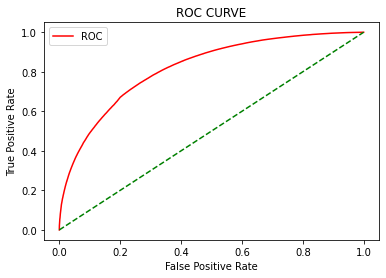



===== ROC AUC SCORE =====
0.8177756263795405


===== BEST PARAMETERS =====


{'lsa__algorithm': 'arpack', 'lsa__n_components': 500}

In [36]:
solver(X=df['new_tweet_stem'],y=df['target'],estimator=LogisticRegression(random_state=42,max_iter=10000),tuning=True,params=param_grid,folds=5,dim_red=True)

Como não foram percebidas melhorias em nenhum dos casos, e a aplicação do LSA é bastante lenta e custosa ao hardware (tempo de execução de cada célula de aproximadamente 3 horas, com falhas devido ao uso total dos 32gb de memória ram), não é visto como necessária a aplicação do LSA à base com lematização. 

Como registro, os melhores resultados encontrados foram de 0.778 accuracy e 0.859 ROC Score, para o modelo de regressão logística utilizando a base limpa, sem stemmer ou lemmatizer.